# Fight-Online-Abuse

### Setup

In [5]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from bs4 import BeautifulSoup
from sklearn import metrics
from torch.utils.data import DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizerFast

from datasets import TextDataset
from models import DistilBertClassifier


In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


### Load the dataset


In [3]:
DATASET_DIR = Path('./datasets/jigsaw-toxic-comment-classification-challenge')
RESULT_DIR = Path('./results')
CHECKPOINT_DIR = Path('./checkpoints')
RESULT_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)

TEXT_FIELD = 'comment_text'
LABEL_FIELDS = ['toxic','severe_toxic','obscene','threat','insult', 'identity_hate']
NUM_LABELS = len(LABEL_FIELDS)

TRAIN_SPLIT = 0.8
MAX_LEN = 128
BATCH_SIZE = 32
LEARNING_RATE = 1e-05
EPOCHS = 10
PRED_THRES = 0.4   

print(f"Labels: {LABEL_FIELDS}")


In [12]:
df = pd.read_csv(DATASET_DIR / 'train.csv', index_col=0)
df.head()


Categories: ['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate']


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Preprocessing

Null values present in training dataset: 0


C:\Python39\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Python39\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Python39\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like req

Cleaning reduced text size by 1.2%


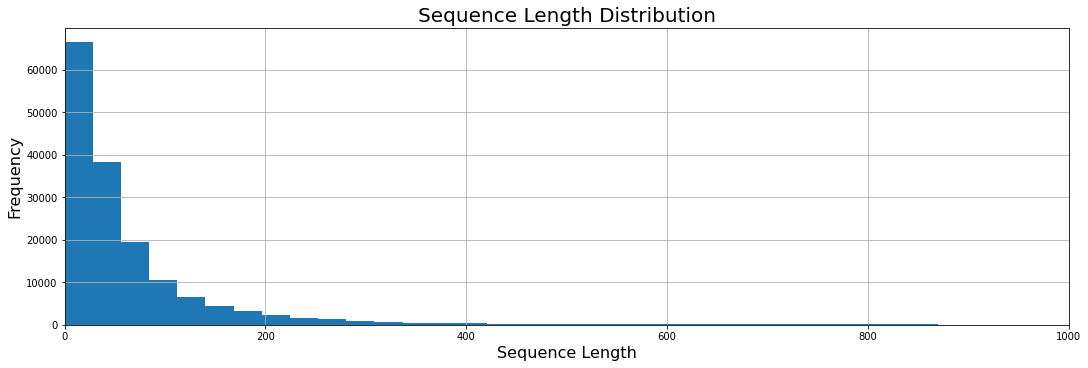

In [13]:
def decontracted(text):
    # specific
    text = re.sub("won't", "will not", text)
    text = re.sub("can't", "can not", text)

    # general
    text = re.sub("n't", " not", text)
    text = re.sub("'re", " are", text)
    text = re.sub("'s", " is", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'t", " not", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'m", " am", text)

    return text

def cleanString(text):
    # ? Remove HTML tags
    text = BeautifulSoup(text).get_text()
    
    # ? Remove contractions
    text = decontracted(text)

    # ? Remove non alphabets characters
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()

    # ? split text into tokens to remove whitespaces
    text = " ".join(text.split())

    return text


# ? Checking for null values
print(f"Null values present in training dataset: {df[TEXT_FIELD].isnull().sum()}")

seq_len_initial = df[TEXT_FIELD].apply(lambda x: len(x.split()))

# ? Cleaning the text
df[TEXT_FIELD] = df[TEXT_FIELD].apply(cleanString)

seq_len_final = df[TEXT_FIELD].apply(lambda x: len(x.split()))
improvement = 100 * (seq_len_final.mean() - seq_len_initial.mean()) / seq_len_initial.mean()

print(f"Cleaning reduced text size by {improvement:.1f}%")

plt.figure(figsize=(15, 5), constrained_layout=True)
plt.hist(seq_len_final, bins=50)
plt.grid(True)
plt.xlim(0, 1000)
plt.title("Sequence Length Distribution", fontsize=20)
plt.xlabel("Sequence Length", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.savefig(RESULT_DIR / "sequence_length_distribution.png", facecolor='w')


### Split into training and validation

In [14]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
dataset = TextDataset(df[TEXT_FIELD], df[LABEL_FIELDS].values, tokenizer, MAX_LEN)

train_size = int(TRAIN_SPLIT * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_dataset)}, Valid size: {len(valid_dataset)}")


Train size: 127656, Valid size: 31915


### Load the model

In [62]:
y_train = train_dataset.dataset.labels[train_dataset.indices]
pos_weight = (y_train==0.).sum(dim=0) / y_train.sum(dim=0)
print(f"Positive weight: {pos_weight}")


Positive weight: tensor([  9.4911,  99.0439,  17.9064, 326.3231,  19.2790, 109.8125])


In [65]:
distilBert = DistilBertModel.from_pretrained("distilbert-base-uncased", num_labels=NUM_LABELS)

# ? Freeze all the parameters
for param in distilBert.parameters():
    param.requires_grad = False

model = DistilBertClassifier(distilBert, NUM_LABELS).to(device)
print(model)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [66]:
def train(model, dataloader, criterion, optimizer, device='cpu'):
    print("Training...")
    model.train()

    total_loss = 0
    total_preds = []

    # ? iterate over batches
    for idx, batch in enumerate(dataloader):
        optimizer.zero_grad()

        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(ids, mask)

        # ? Compute the loss between actual and predicted values
        loss = criterion(outputs, labels)

        # ? Calculate the gradients via backpropagation
        loss.backward()
        # ? clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # ? Update the model parameters
        optimizer.step()

        total_loss = total_loss + loss.item()
        total_preds.append(outputs.detach().cpu().numpy())

        # ? progress update after every 50 batches.
        if (idx + 1) % 50 == 0:
            print(f"  [Batch {idx+1}\t/{len(dataloader)}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    total_preds = total_preds.reshape(-1, total_preds.shape[-1])

    return avg_loss, total_preds


train_loss, train_preds = train(model, train_dataloader, criterion, optimizer, device)


Training...
  [Batch 50	/3990] Loss: 3.2857
  [Batch 100	/3990] Loss: 1.3849
  [Batch 150	/3990] Loss: 0.7804
  [Batch 200	/3990] Loss: 0.7296
  [Batch 250	/3990] Loss: 1.0126
  [Batch 300	/3990] Loss: 3.5447
  [Batch 350	/3990] Loss: 2.8762
  [Batch 400	/3990] Loss: 0.7378
  [Batch 450	/3990] Loss: 0.6616
  [Batch 500	/3990] Loss: 1.7465
  [Batch 550	/3990] Loss: 0.9239
  [Batch 600	/3990] Loss: 1.3230
  [Batch 650	/3990] Loss: 1.0710
  [Batch 700	/3990] Loss: 3.4412
  [Batch 750	/3990] Loss: 0.7549
  [Batch 800	/3990] Loss: 0.7210
  [Batch 850	/3990] Loss: 0.8419
  [Batch 900	/3990] Loss: 0.5034
  [Batch 950	/3990] Loss: 0.6335
  [Batch 1000	/3990] Loss: 0.6896
  [Batch 1050	/3990] Loss: 0.6937
  [Batch 1100	/3990] Loss: 0.4509
  [Batch 1150	/3990] Loss: 0.8828
  [Batch 1200	/3990] Loss: 0.4649
  [Batch 1250	/3990] Loss: 0.8438
  [Batch 1300	/3990] Loss: 0.5378
  [Batch 1350	/3990] Loss: 1.5059
  [Batch 1400	/3990] Loss: 0.6444
  [Batch 1450	/3990] Loss: 0.6789
  [Batch 1500	/3990] L

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
# function for evaluating the model
def evaluate(dataloader, criterion, device):
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    for step, batch in enumerate(dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [ ]:
# # ? tokenize and encode sequences
# tokens_train = tokenizer(X_train.tolist(), max_length=256, padding='max_length', truncation=True)
# train_seq = torch.tensor(tokens_train['input_ids'])
# train_mask = torch.tensor(tokens_train['attention_mask'])
# train_y = torch.tensor(y_train.tolist())
# train_dataset = TensorDataset(train_seq, train_mask, train_y)
# train_sampler = RandomSampler(train_dataset)
# train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
